In [2]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import tensorflow as tf

import csv
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import re
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
import gensim.downloader as gensim_api

import transformers

RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
No module named 'keras.engine'

In [22]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
with open("tweets.csv", 'r') as file:
  csvreader = csv.reader(file)
  corpus = file.read()
  for row in csvreader:
    print(row)

In [24]:
df = pd.read_csv("tweets.csv", encoding='utf-8')

df.rename(columns = {'Lionel Messi and his Argentina teammates have been airlifted out after their World Cup homecoming was brought to a standstill by millions of celebrating fans. https://t.co/GOIn1wbvuJ\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t':'text'}, inplace = True)

df['text'] = df['text'].replace({'"':''}, regex=True)
df['text'] = df['text'].replace({"'":''}, regex=True)
df['text'] = df['text'].replace({u"\U0001F600-\U0001F64F":''}, regex=True)
df['text'] = df['text'].replace({u"\U0001F300-\U0001F5FF":''}, regex=True)
df['text'] = df['text'].replace({u"\U0001F680-\U0001F6FF":''}, regex=True)
df['text'] = df['text'].replace({u"\U0001F1E0-\U0001F1FF":''}, regex=True)
df['text'] = df['text'].replace({u"\U00002500-\U00002BEF":''}, regex=True)
df['text'] = df['text'].replace({u"\U00002702-\U000027B0":''}, regex=True)
df['text'] = df['text'].replace({u"\U000024C2-\U0001F251":''}, regex=True)
df['text'] = df['text'].replace({u"\U0001f926-\U0001f937":''}, regex=True)
df['text'] = df['text'].replace({u"\U00010000-\U0010ffff":''}, regex=True)
df['text'] = df['text'].replace({u"\u2640-\u2642":''}, regex=True)
df['text'] = df['text'].replace({u"\u2600-\u2B55":''}, regex=True)
df['text'] = df['text'].replace({u"\u200d":''}, regex=True)
df['text'] = df['text'].replace({u"\u23cf":''}, regex=True)
df['text'] = df['text'].replace({u"\u23e9":''}, regex=True)
df['text'] = df['text'].replace({u"\u231a":''}, regex=True)
df['text'] = df['text'].replace({u"\ufe0f":''}, regex=True)
df['text'] = df['text'].replace({u"\u3030":''}, regex=True)

df

,text
0,"Real Madrid star, Toni Kroos backtracks on cla..."
1,Lionel Messis World Cup Instagram post has bec...
2,Lionel Messi and Argentina’s World Cup heroes ...
3,The World Cup has never looked so beautiful in...
4,Lionel Messi and Argentinas World Cup heroes f...
...,...
51324,👋Qatar invites radical Muslim preacher Dr. Zak...
51325,Less than 12 hours left to historic world cup ...
51326,FIFA has named Palestinian refugee and social ...
51327,Iranians are accused of #Islamophobia for tell...


In [25]:
#sentiment analysis of the tweets
#bert is an unsupervised learning model
#run bert and fine tune it with 500 tweets that have been manually classified
#categories of the tweets: ISLAM(Allah, muslim, islam, Qatar, mena, Quran), RIGHTS(LGBTQ, human rights, abuse, labour, punishment), MEDIA(misrepresentation, arab, bias, criticism)



#will label and run bert to classsify the tweets and do sentiment analysis. End goal: to have an input text that will be classified as positive or negative and tell you the category that it belongs to 

In [26]:

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [27]:
#obtain stopwords and apply to text column. to create a new column called text_clean
lst_stopwords = (nltk.corpus.stopwords.words("english"))
print(lst_stopwords)


df["text_clean"] = df["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,text,text_clean
0,"Real Madrid star, Toni Kroos backtracks on cla...",real madrid star toni kroos backtracks claim c...
1,Lionel Messis World Cup Instagram post has bec...,lionel messis world cup instagram post become ...
2,Lionel Messi and Argentina’s World Cup heroes ...,lionel messi argentina world cup hero fly buen...
3,The World Cup has never looked so beautiful in...,world cup never looked beautiful eye lionel me...
4,Lionel Messi and Argentinas World Cup heroes f...,lionel messi argentina world cup hero fly buen...


In [28]:
## Function to apply BERT to text
nlp = gensim_api.load("glove-wiki-gigaword-300")


def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}

dic_clusters["ISLAM"] = get_similar_words(['allah','muslim','islam','qatar', 'mena', 'quran'],top=30, nlp=nlp)
dic_clusters["RIGHTS"] = get_similar_words(['lgbtq','human','rights','abuse','labour', 'punishment'], top=30, nlp=nlp)
dic_clusters["MEDIA"] = get_similar_words(['misrepresentation','arab','bias','criticism', 'media'],top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ISLAM :  ['muhammad', 'mosque', 'ibn', 'mohammed', 'sheikh'] ... 36
RIGHTS :  ['sexual', 'abuse', 'criminal', 'child', 'advocacy'] ... 36
MEDIA :  ['criticised', 'perception', 'saying', 'negative', 'allegations'] ... 35


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/var/folders/v8/fcy2tkcd1fb19mqly4z9nvy40000gn/T/ipykernel_11145/2176675666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf = dtf.append(dtf_group)
/var/folders/v8/fcy2tkcd1fb19mqly4z9nvy40000gn/T/ipykernel_11145/2176675666.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf = dtf.append(dtf_group)
/var/folders/v8/fcy2tkcd1fb19mqly4z9nvy40000gn/T/ipykernel_11145/2176675666.py:

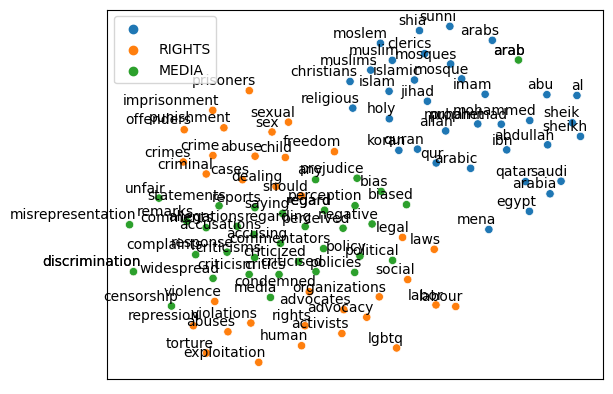

In [29]:
#applying a TSNE to the dictionary of keywords

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)
        
## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

In [30]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) 
                 for txt in df["text_clean"]]
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

In [ ]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v
         in dic_clusters.items()}

## create the feature matrix (n news x 768)
ct = ColumnTransformer([('town', OneHotEncoder(), [0])], remainder = 'passthrough')

X.ndim


NameError: name 'dic_clusters' is not defined

In [ ]:
X = ct.fit_transform(X)

X.ndim

# X.reshape(-1, 1)

similarities = np.array(
            [metrics.pairwise.cosine_similarity(X, y).T.tolist()[0] 
             for y in dic_y.values()]
            ).T



# ## adjust and rescale
# labels = list(dic_y.keys())
# for i in range(len(similarities)):
#     ### assign randomly if there is no similarity
#     if sum(similarities[i]) == 0:
#        similarities[i] = [0]*len(labels)
#        similarities[i][np.random.choice(range(len(labels)))] = 1
#     ### rescale so they sum = 1
#     similarities[i] = similarities[i] / sum(similarities[i])

# ## classify the label with highest similarity score
# predicted_prob = similarities
# predicted = [labels[np.argmax(pred)] for pred in predicted_prob]


NameError: name 'ct' is not defined